In [1]:
from typing import List

import numpy as np
import csv
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS, BASE_COLORS
from scipy.stats import sem
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from itertools import product
from random import shuffle

colors = list(BASE_COLORS.keys()) # + list(TABLEAU_COLORS.keys())
shuffle(colors)
print(colors)

['c', 'k', 'g', 'm', 'w', 'r', 'b', 'y']


In [2]:
# noise_ws = [0.0, 0.3, 0.75, 1.0]
noise_ws = [0.0]
# reward_ws = [0.0, 0.3, 0.6, 1.0]
reward_ws = [0.4]
seeds = [12, 42, 69, 10420]
# seeds = [128, 4242, 1234, 48]
# seeds = [12, 42, 69, 10420, 128, 4242, 1234, 48]
# postfix = '_arch'
postfix = ''
# experiment = 'poster_mal_agent_reward'
# experiment = 'report_mal_noise'
# experiment = 'report_mal_noise_reward'
experiment = 'delete_this'

In [4]:
def interpolate(x, y, at):
    return interp1d(x, y, kind="linear", fill_value=(np.min(y), np.max(y)), bounds_error=False)(at)

def plot(all_evals: List, label: str, smooth_factor=2, color="b", linestyle=None, max_samples=None, eval_rate=None, plot_std=True):
    intervals = np.arange(0, max_samples, eval_rate)
    all_evals = np.stack([interpolate(np.array(evals)[:,0],np.array(evals)[:,1],intervals) for evals in all_evals])
    mean_reward = all_evals.mean(axis=0)
    sem_reward = sem(all_evals, axis=0)
    ci_95 = 1.96 * sem_reward

    mean_reward_smooth = gaussian_filter1d(mean_reward, smooth_factor)
    ci_95_smooth = gaussian_filter1d(ci_95, smooth_factor)

    plt.plot(intervals, mean_reward_smooth, label=label, color=color, linestyle=linestyle)
    if plot_std: plt.fill_between(intervals, mean_reward_smooth - ci_95_smooth, mean_reward_smooth + ci_95_smooth, color=color, alpha=0.2)

def load_evals(path):
    path = Path(path)
    assert path.exists()
    with open(path, newline='') as file:
        rd = csv.reader(file)
        return np.array(list(rd), dtype='float')

[PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/delete_this/sample_efficiency/noise_0.0_reward_0.4_seed_12'), PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/delete_this/sample_efficiency/noise_0.0_reward_0.4_seed_42'), PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/delete_this/sample_efficiency/noise_0.0_reward_0.4_seed_69'), PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/delete_this/sample_efficiency/noise_0.0_reward_0.4_seed_10420')]


/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


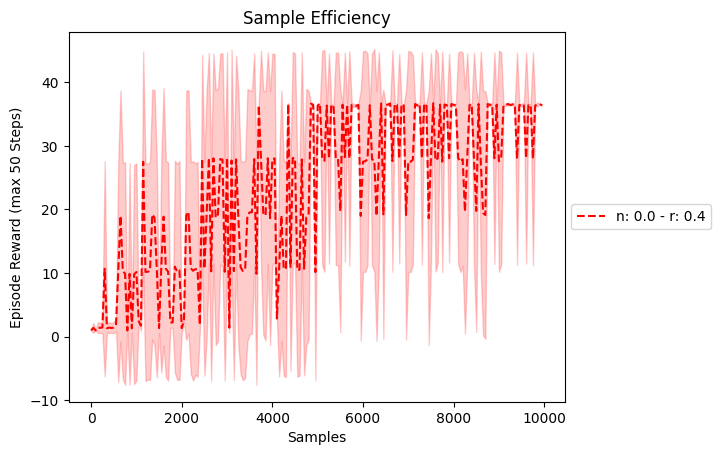

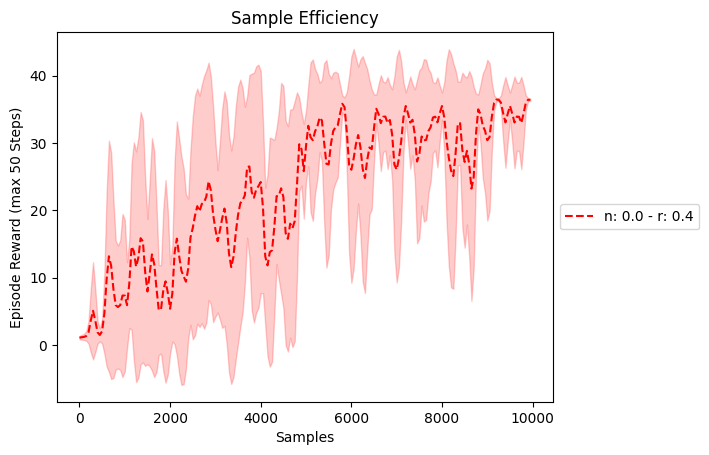

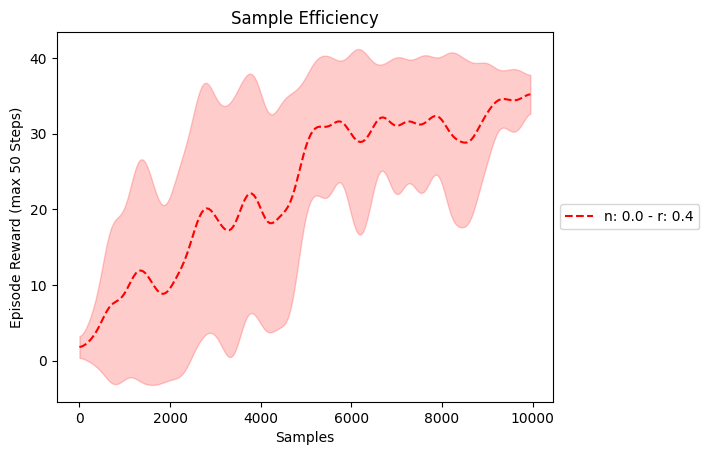

In [31]:
path = Path.cwd()
path = path / "stackelberg_mbrl" / "experiments" / experiment / "sample_efficiency"
stems = list(product(noise_ws, reward_ws))
paths = [path / f"noise_{noise}_reward_{reward}_seed_{seed}{postfix}" for (noise, reward), seed in product(stems, seeds)]
print(paths)
evals = np.stack(load_evals(p) for p in paths)
max_samples = np.max(evals[:, :, 0])
pts_cnt = evals.shape[1]
evals = evals.reshape(-1, len(seeds), pts_cnt, 2)

# plt.style.use('dark_background')
plt.style.use('default')
for smooth_factor in [0.0001, 1, 4]:
    plt.figure()
    # smooth_factor = 20.0
    for e, (noise, reward), (c, s) in zip(evals, stems, product(['r', 'g', 'b', 'c', 'y'], ['--','-','-.',':'])):
        plot(e, f"n: {noise} - r: {reward}", smooth_factor=smooth_factor, max_samples=max_samples, eval_rate=50, color=c, linestyle=s)
        
    plt.title("Sample Efficiency")
    plt.ylabel("Episode Reward (max 50 Steps)")
    plt.xlabel("Samples")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# This part is just for creating data

In [ ]:
## TODO move this as well

%load_ext autoreload
%autoreload 2

from stackelberg_mbrl.experiments.experiment_config import ExperimentConfig, EnvConfig, PolicyConfig, WorldModelConfig, LoadPolicy, LeaderEnvConfig, SampleEfficiency
from stackelberg_mbrl.train_mal import train_contextualized_MAL
from itertools import product

for reward_w, noise_w, seed in product(reward_ws, noise_ws, seeds):
    config = ExperimentConfig(
        experiment_name=experiment,
        env_config=EnvConfig(
            env_true_id="simple_mdp_2",
            env_eval_id="simple_mdp_2",
            max_episode_steps=50
        ),
        policy_config=LoadPolicy(
            # just use the same one...
            path="stackelberg_mbrl/experiments/poster_mal_agent_reward/checkpoints/policy_simple_mdp_2.zip",
        ),
        # policy_config=PolicyConfig(
        #     pretrain_iterations=1,
        #     samples_per_training_iteration=1_000_000,
        #     model_save_name="policy_simple_mdp_2",
        # ),
        leader_env_config=LeaderEnvConfig(
            env_noise_weight=lambda step: noise_w,
            env_reward_weight=reward_w,
        ),
        sample_efficiency=SampleEfficiency(
            sample_eval_rate=50,
            n_eval_episodes=30,
            max_samples=10_000,
            log_save_name=f"noise_{noise_w}_reward_{reward_w}_seed_{seed}{postfix}"
        ),
        world_model_config=WorldModelConfig(
            total_training_steps=250_000,
            # total_training_steps=1_000,
            # model_save_name="simple_mdp_2",
        ),
        seed=seed
    )

    train_contextualized_MAL(config, verbose=True)

# Optuna hyperparameter tuning...

### results

{'learning_rate': 0.13642027541738172, 'env_reward_weight': 0.8546471786192158, 'env_noise_weight': 0.13496615825145525}

In [ ]:
# moved to pytuna-mal.py

# Optuna does not work, just do my own ablation studies

In [2]:
# moved to ablation-mal.py

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


(8, 5, 401, 2)


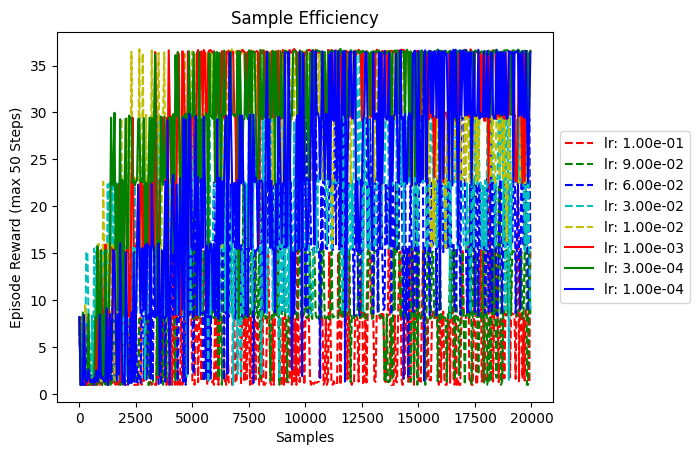

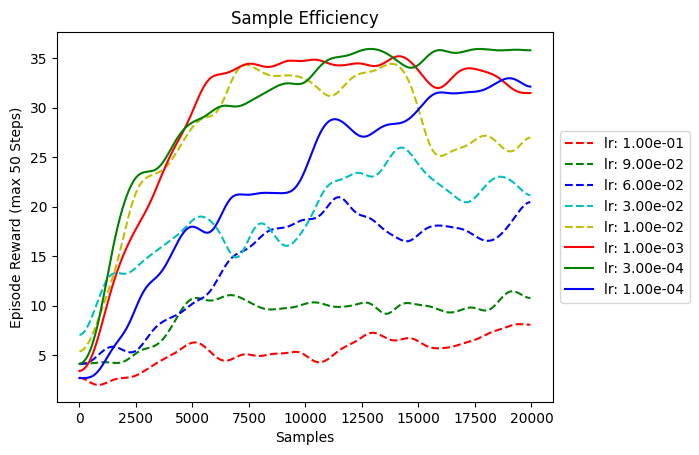

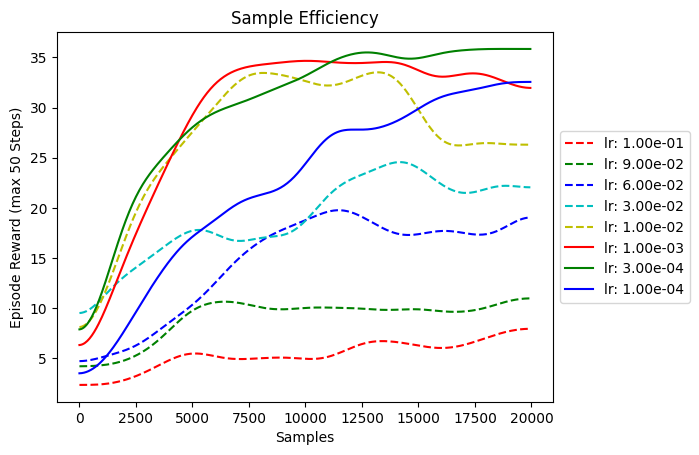

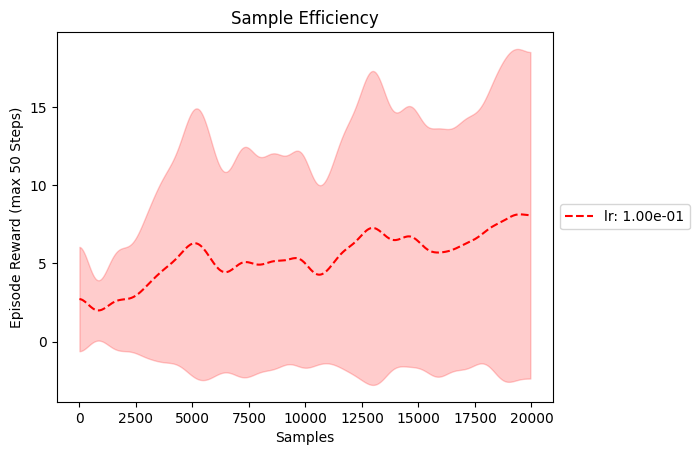

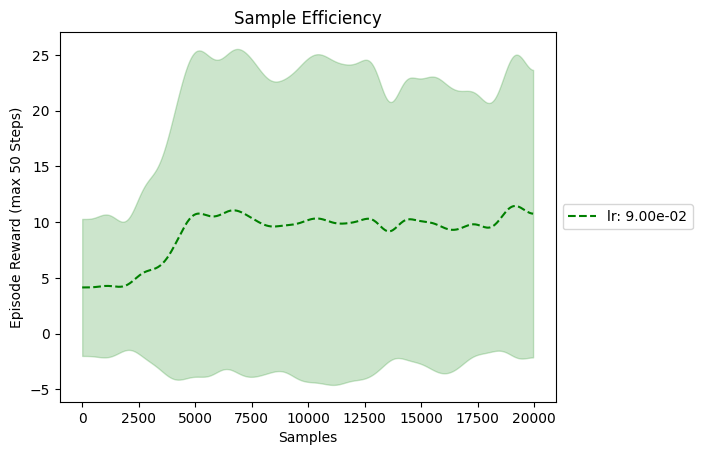

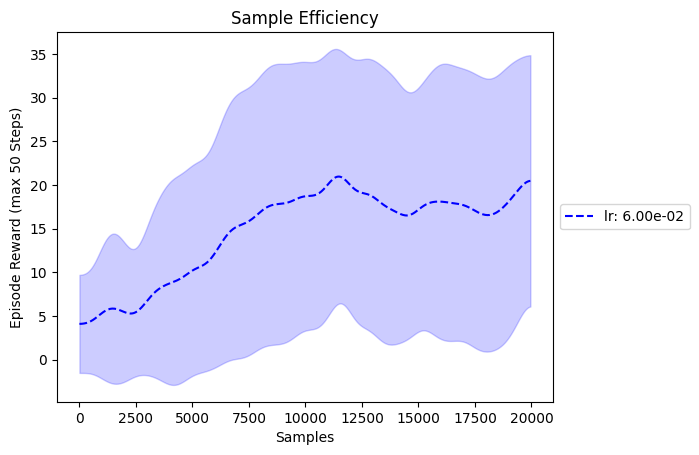

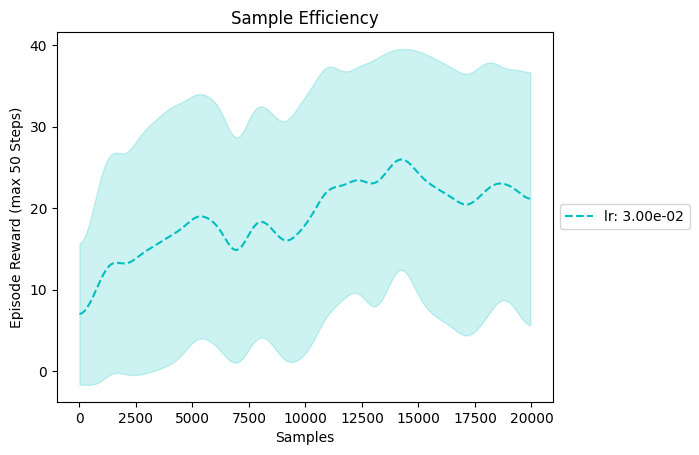

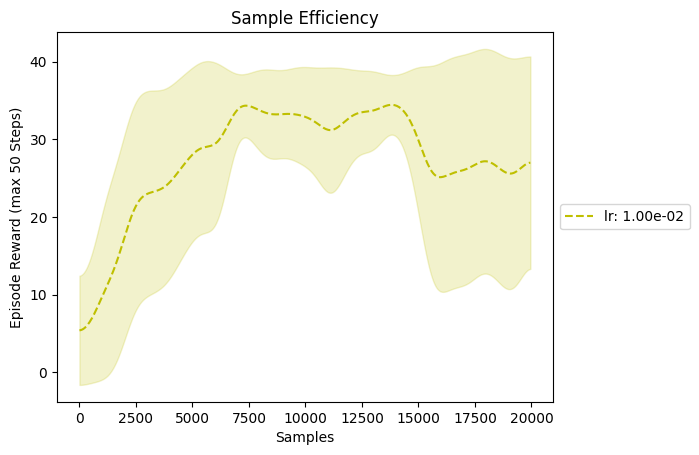

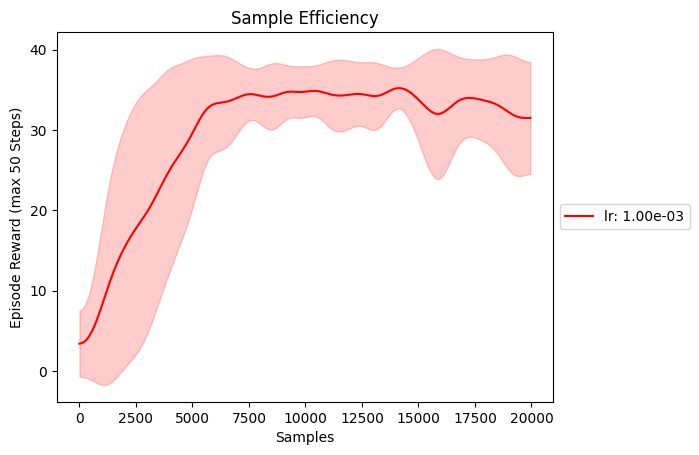

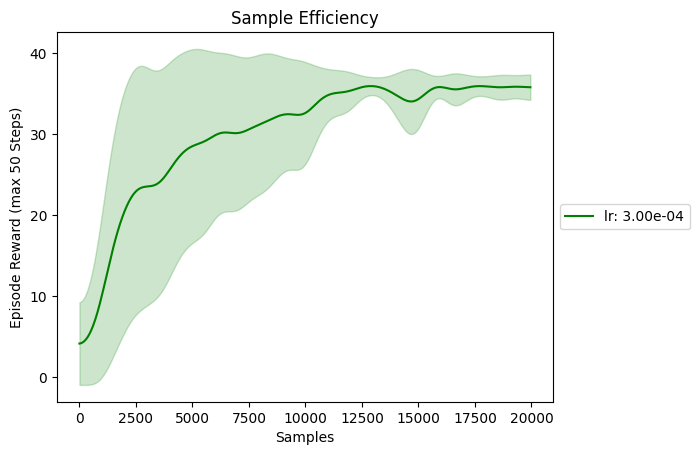

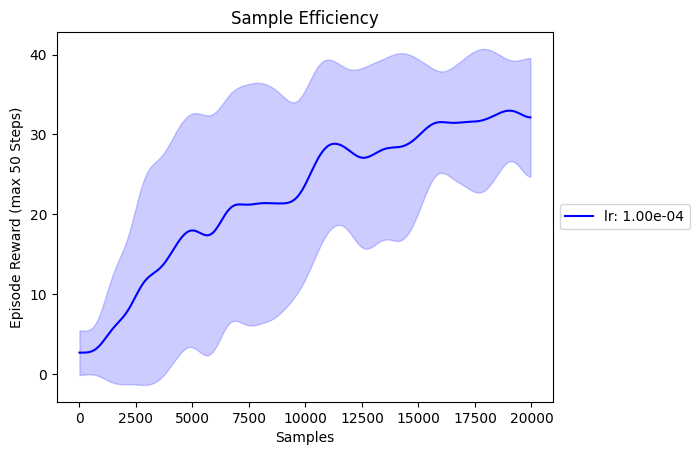

In [14]:
seeds = [23242, 234469, 3987, 128, 411234]
learning_rates = [1e-1, 9e-2, 6e-2, 3e-2, 1e-2, 1e-3, 9e-4, 6e-4, 3e-4, 1e-4]

path = Path.cwd()
path = path / "stackelberg_mbrl" / "experiments" / 'mal_lr_ablation' / "sample_efficiency"
stems = learning_rates
getpath = lambda lr, seed: path / f"lr_{lr}_seed_{seed}"
stems = list(filter(lambda lr: all([getpath(lr, seed).exists() for seed in seeds]), stems))
paths = [getpath(lr, seed) for lr, seed in product(stems, seeds)]
evals = np.stack(load_evals(p) for p in paths)
max_samples = np.max(evals[:, :, 0])
pts_cnt = evals.shape[1]
evals = evals.reshape(-1, len(seeds), pts_cnt, 2)

print(evals.shape)

# plt.style.use('dark_background')
plt.style.use('default')
for smooth_factor in [0.0001, 10, 20]:
    plt.figure()
    # smooth_factor = 20.0
    for e, lr, (s, c) in zip(evals, stems, product(['--','-','-.',':'], ['r', 'g', 'b', 'c', 'y'])):
        plot(e, f"lr: {lr:.2e}", smooth_factor=smooth_factor, max_samples=max_samples, eval_rate=50, color=c, linestyle=s, plot_std=False)
        
    plt.title("Sample Efficiency")
    plt.ylabel("Episode Reward (max 50 Steps)")
    plt.xlabel("Samples")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


for e, lr, (s, c) in zip(evals, stems, product(['--','-','-.',':'], ['r', 'g', 'b', 'c', 'y'])):
    plt.figure()
    smooth_factor = 10
    plot(e, f"lr: {lr:.2e}", smooth_factor=smooth_factor, max_samples=max_samples, eval_rate=50, color=c, linestyle=s)
        
    plt.title("Sample Efficiency")
    plt.ylabel("Episode Reward (max 50 Steps)")
    plt.xlabel("Samples")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(1, 5, 1, 2)


/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


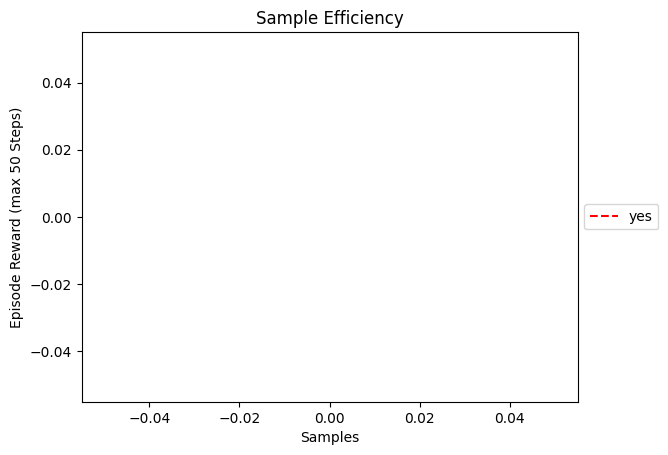

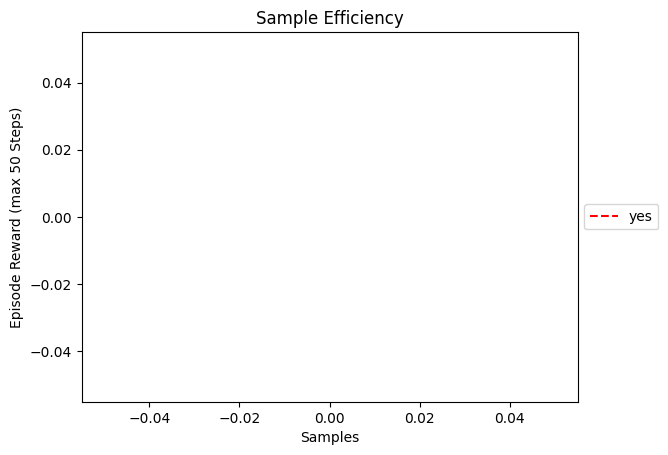

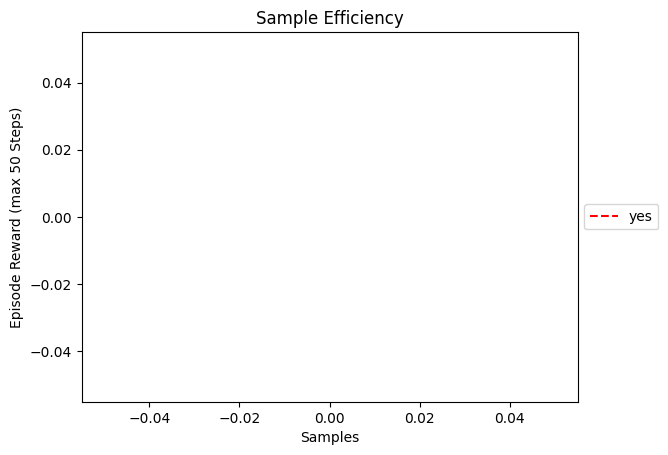

In [10]:
seeds = [23242, 234469, 3987, 128, 411234]

path = Path.cwd()
path = path / "stackelberg_mbrl" / "experiments" / 'pal_sample_efficiency' / "sample_efficiency"
getpath = lambda seed: path / f"seed_{seed}"
paths = [getpath(seed) for seed in seeds]
evals = np.stack(load_evals(p) for p in paths)
max_samples = np.max(evals[:, :, 0])
pts_cnt = evals.shape[1]
evals = evals.reshape(-1, len(seeds), pts_cnt, 2)

print(evals.shape)

# plt.style.use('dark_background')
plt.style.use('default')
for smooth_factor in [0.0001, 10, 20]:
    plt.figure()
    # smooth_factor = 20.0
    for e, (s, c) in zip(evals, product(['--','-','-.',':'], ['r', 'g', 'b', 'c', 'y'])):
        plot(e, f"yes", smooth_factor=smooth_factor, max_samples=max_samples, eval_rate=50, color=c, linestyle=s, plot_std=False)
        
    plt.title("Sample Efficiency")
    plt.ylabel("Episode Reward (max 50 Steps)")
    plt.xlabel("Samples")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# for e, lr, (s, c) in zip(evals, stems, product(['--','-','-.',':'], ['r', 'g', 'b', 'c', 'y'])):
#     plt.figure()
#     smooth_factor = 10
#     plot(e, f"lr: {lr:.2e}", smooth_factor=smooth_factor, max_samples=max_samples, eval_rate=50, color=c, linestyle=s)
        
#     plt.title("Sample Efficiency")
#     plt.ylabel("Episode Reward (max 50 Steps)")
#     plt.xlabel("Samples")
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))